# Time Series Forecasting mit rekurrenten neuronalen Netzen
Dieses Notebook entsteht im Rahmen des Moduls `Deep Learning` an der Fachhochschule Südwestfalen. Es beschäftigt sich mit dem Thema `Time Series Forecasting` und untersucht die Anwendung von rekurrenten neuronalen Netzen (RNN) auf Zeitreihendaten....

## 1. Einleitung

## 2. Was ist Time Series Forecasting (Zeitreihenvorhersage)?

Christian

Definition gemäß der Webseite Studysmarter:<br>
**Zeitreihenprognose** ist eine statistische Methode zur Vorhersage zukünftiger Ereignisse oder Werte, indem historische Zeitreihendaten analysiert und Muster erkannt werden. [C1]

Beispiele:<br>
- Wetterdaten für zukünftiges Wetter (https://www.studysmarter.de/studium/mathematik-studium/statistik-studium/zeitreihenprognose/)
- Aktienkurse für zukünftige Aktienverläufe
- Passagierzahlen für zukünftige Passagiervorhersagen (https://data-science-crashkurs.de/chapters/kapitel_09.html)

Die Seite https://www.emft.fraunhofer.de/de/kompetenzen/systemloesungen-ki/ki-algorithmen-zeitreihenanalyse.html nennt zudem noch folgende mögliche Beispiele:
- Industrie 4.0 mit IIoT (Industrial Internet of Things)
- Logistik
- Finanzen
- Stromnetze
- Internetverkehr
- Umweltmonitoring
- Gesundheitsdaten

Außerdem werden auf der Seite typische Methoden der künstlichen Intelligenz inklusive grafischer Beispiele genannt, wie z.B.: Regression, Klassifikation, Anomalieerkennung, Vorhersage

Grafisches Beispiel einer Klassifikation:<br>
<img style = 'border: 5px solid #555' src="Pictures/classification-dt-mls-emft.jpg" width="30%" alt="Grafisches Beispiel einer Klassifikation"> 
<br>
Grafisches Beispiel einer Anomalieerkennung:<br>
<img style = 'border: 5px solid #555' src="Pictures/anomaly-dt-mls-emft.jpg" width="30%" alt="Grafisches Beispiel einer Anomalieerkennung">
<br>
Grafisches Beispiel einer Anomalieerkennung:<br>
<img style = 'border: 5px solid #555' src="Pictures/forecasting-dt-mls-emft.jpg" width="30%" alt="Grafisches Beispiel einer Vorhersage">

### Einlesen einer CSV-Tabelle
Das nachfolgende angepasste Beispiel verwendet als Grundlage Fahrgastzähldaten für Bus und Bahn aus Chicago [C2][C3, pp. 583-594]

Dabei wird die zur Verfügung stehende CSV-Datei eingelesen. Die Tabelle wird angepasst durch Setzen von kürzeren Spaltennamen, Datumssortierung und Entfernen von Duplikaten. Die "total" Spalte wird zusätzlich entfernt, da sie für das Beispiel nicht benötigt wird.


In [67]:
import pandas as pd
from pathlib import Path

path = Path("Data/CTA_-_Ridership_-_Daily_Boarding_Totals_20241229.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)
df = df.drop_duplicates()
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


Zu den Daten (erste fünf Tage der Zeitreihe) werden jeweils die Fahrgastzahlen für Bus und Bahn angegeben. Als Tagtyp sind A, U und W möglich, wobei A für Samstage, U für Sonn- und Feiertage und W für Wochentage steht. 

## Ausgabe als Graph
Die Zeitreihe hat die Eigenschaft **multivariat**, da pro Zeiteinheit zwei Werte angegeben sind.
Gibt man die Daten als Grafik über drei Monate aus, sieht es wie folgt aus.

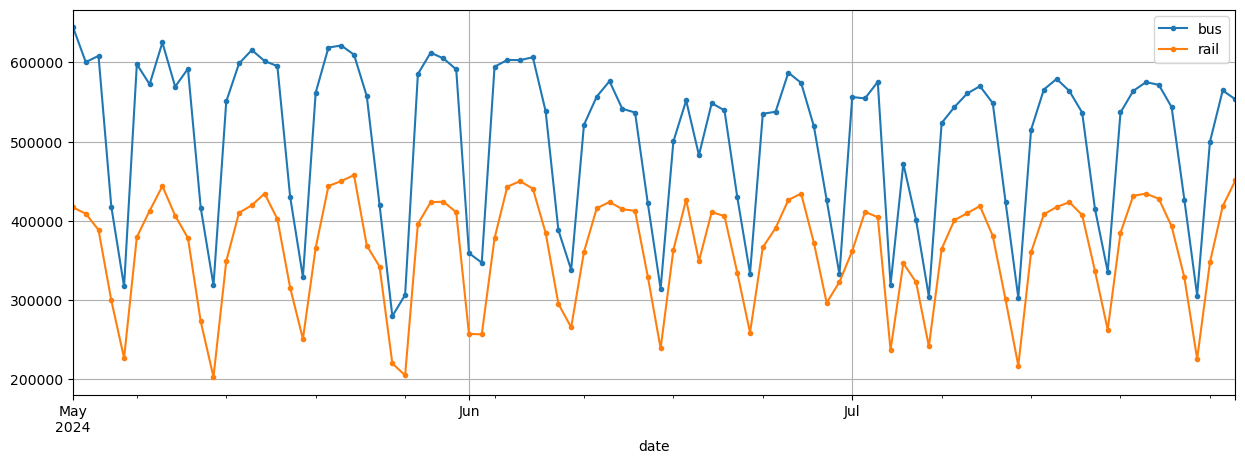

In [32]:
import matplotlib.pyplot as plt

df["2024-05":"2024-07"].plot(grid=True, marker=".", figsize=(15,5))
plt.show()

## Naives Forcasting und Differencing
Da die Daten wöchentlich saisonal sind, wäre ein erster Ansatz ein **naives Forecasting**, indem man Werte aus der Vergangenheit über einen gleichen Zeitraum auf die aktuellen Werte legt und diese dann vergleicht. Die Daten aus der Vergangenheit werden um vier Wochen nach rechts verschoben, um die Graphen bildlich miteinander zu vergleichen. Außerdem werden die Differenzen der jeweiligen Tage in einer separaten Grafik mit ausgegeben (**Differencing**).

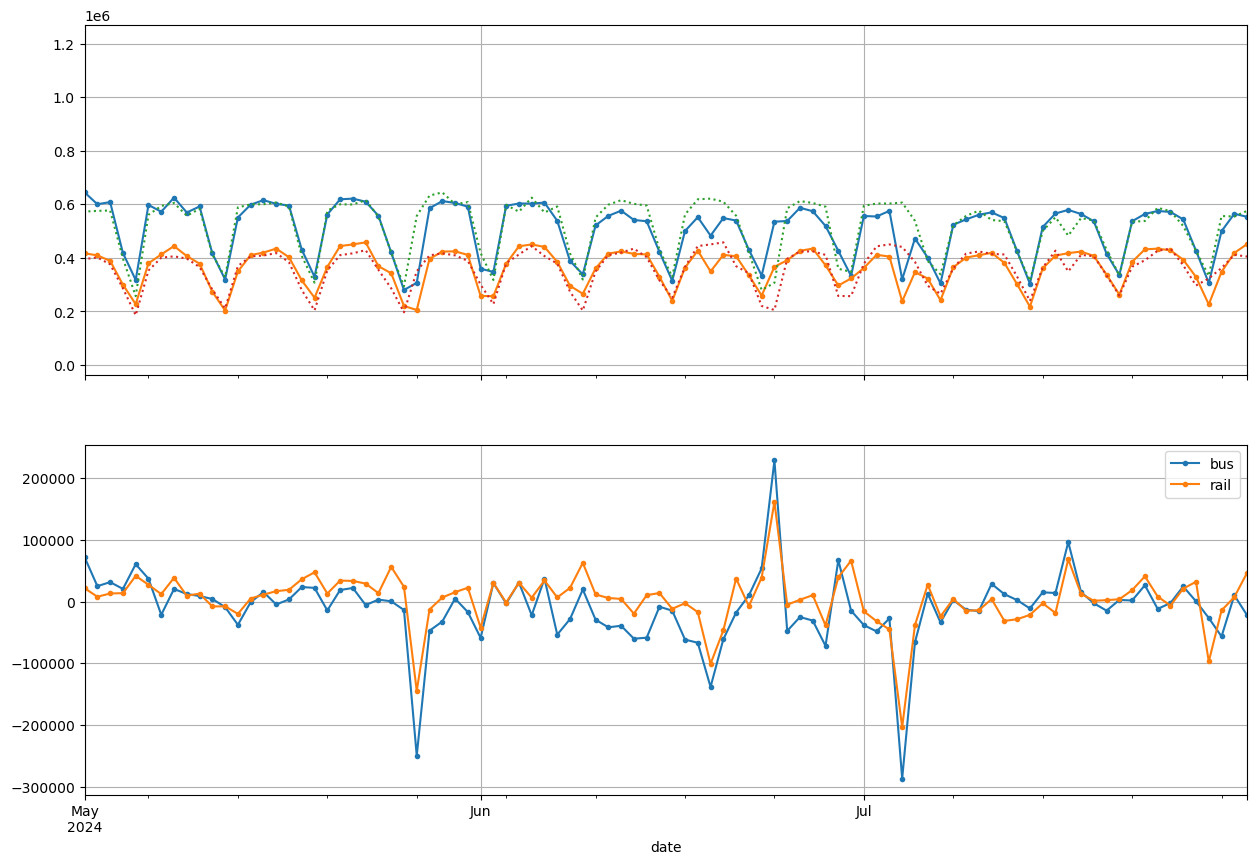

In [33]:
diff_28 = df[["bus", "rail"]].diff(28)["2024-05":"2024-07"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,10))
df.plot(ax = axs[0], legend=False, marker=".") #ursprüngliche Zeitserie
df.shift(28).plot(ax=axs[0], grid=True, legend=False, linestyle=":") #verschobene Zeitserie
diff_28.plot(ax=axs[1], grid=True, marker=".")

plt.show()


Man erkennt zwei besonders hohe negative Differenzen: Einmal für Ende Mai und einmal für Anfang Juli.<br> 
Bei einem Vergleich der Tagtypen in den jeweiligen Wochen fällt auf, dass am 27. Mai (Memorial Day) und am 04. Juli (Amerikanischer Unabhängigkeitstag) jweils ein Feiertag war.

In [34]:
print(list(df.loc["2024-05-24":"2024-05-30"]["day_type"]))
print(list(df.loc["2024-07-01":"2024-07-07"]["day_type"]))

['W', 'A', 'U', 'U', 'W', 'W', 'W']
['W', 'W', 'W', 'U', 'W', 'A', 'U']


### MAE und MAPE
Verwenden des mittleren absoluten Fehlers (Mean Absolute Error - **MAE**) und <br>
mittlerer absoluter prozentualer Fehler (Mean Absolute Percentage Error - **MAPE**)
Für naives Forcasting ist insbesondere der **MAPE** sehr gut, kann aber noch verbessert werden.

In [36]:
print(diff_28.abs().mean())
targets = df[["bus", "rail"]]["2024-05":"2024-07"]
print("")
print((diff_28 / targets).abs().mean())

bus     35114.543478
rail    27876.956522
dtype: float64

bus     0.078065
rail    0.088024
dtype: float64


### Prüfung jährliche Saisonalität
Weiteres Beispiel zur Prüfung einer jährlichen Saisonalität inklusive des Einbruchs von Fahrgastzahlen während der Corona-Pandemie.<br>
Zusätzlich **Differencing** um 12 Monate zum Entfernen der jährlichen Saisonalität und begradingen von Trends.

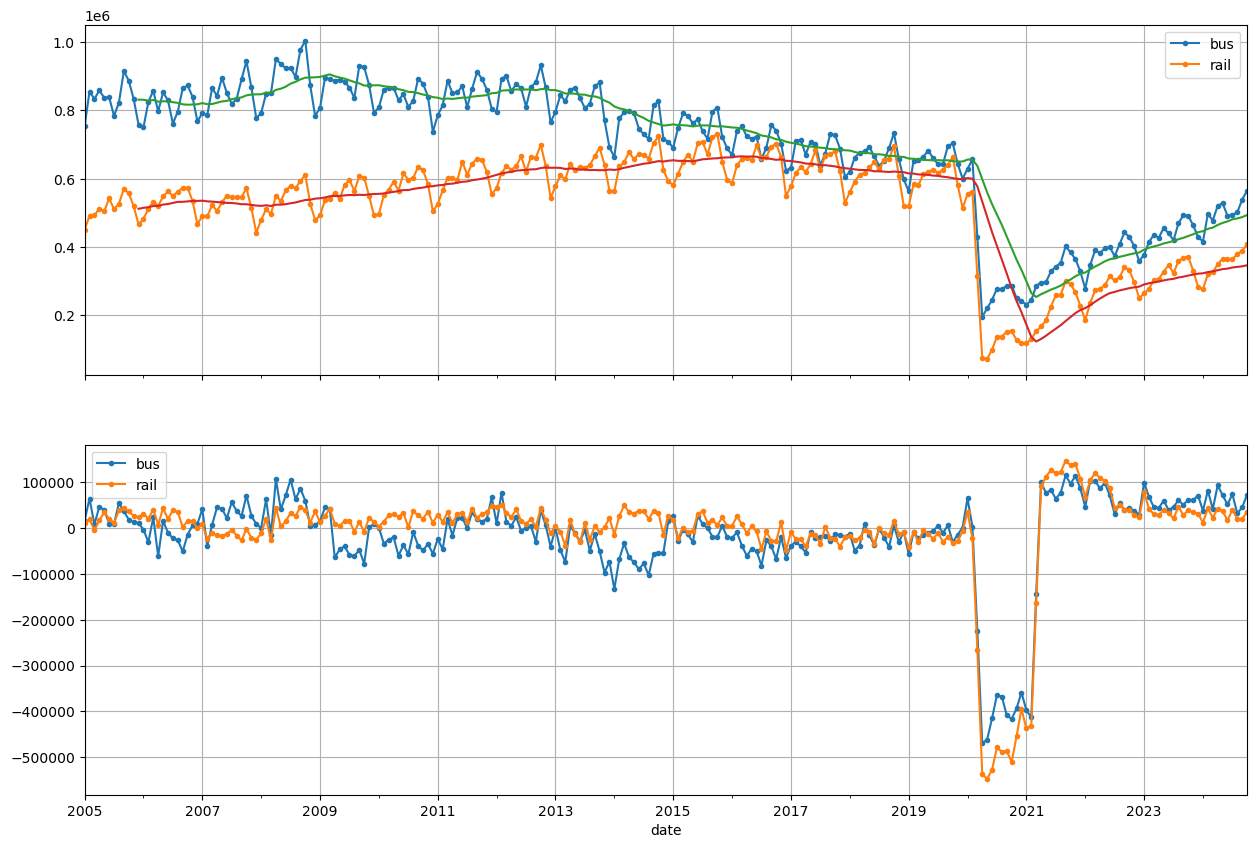

In [66]:
period = slice("2005", "2024")
df_temp = df.drop("day_type", axis=1)
df_monthly = df_temp.resample('M').mean() #Mittelwert für jeden Monat
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, axs = plt.subplots(2,1,sharex=True, figsize=(15,10))
df_monthly[period].plot(ax=axs[0], marker=".")
rolling_average_12_months.plot(ax=axs[0], grid=True, legend=False)
#plt.show()

df_monthly.diff(12)[period].plot(ax=axs[1], grid=True, marker=".")
plt.show()

Quellen:
* C1: StudySmarter GmbH. (2024) Zeitreihenprognose: Methoden & Anwendung | StudySmarter. https://www.studysmarter.de/studium/mathematik-studium/statistik-studium/zeitreihenprognose/. 29.12.2024
* C2: https://homl.info/ridership
* C3: Géron Aurélien, Praxiseinstieg Machine Learning mit Scikit-Learn, Keras und TensorFlow, 3. Auflage, 2023, 978-3-96009-212-4

## 3. Was sind recurrent neural networks (Rekurrente neuronale Netzwerke)?

Ein rekurrentes oder auch rückgekoppeltes neuronales Netzwerk (RNN) ist ein künstliches neuronales Netzwerk, dass bei jeder Verarbeitung einer Einheit auch ein Ergebnis aus einer früheren Iteration erhält. Damit eignet es sich besonders für die Verarbeitung von sequentiellen Daten, wie z.B. Zeitreihendaten, Text oder Sprache.
Ein RNN funktioniert, indem es eine spezielle Ausgabe des vorherigen Schrittes, den hidden state oder auch state vector, als zusätzlichen Input für den nächsten Schritt verwendet. Das bedeutet, dass immer zwei Ausgaben generiert werden. Dadurch kann es sich an vorherige Iterationen erinnern und somit auch auf längere Abhängigkeiten in den Daten reagieren. Das eigentliche Ergebnis wird dabei nur im letzten Schritt betrachtet. [T1, S. 116ff]

<img style = 'border: 5px solid #555' src="Pictures/rnn-ablauf.png" width="30%" alt="Ablauf eines RNN">

[T1, S. 117]

Das Bild zeigt den sequentiellen Ablauf eines RNN. Dabei bezeichnet "t" den aktuellen Schritt. Diese Schritte könnten bei der Verarbeitung von Text z.B. einzelne Wörter oder Buchstaben sein. Der hidden state wird dabei in jedem Schritt aktualisiert und an den nächsten Schritt weitergegeben.

Die Verarbeitung einer Interation erfolgt dabei in drei Schritten die in folgendem Bild dargestellt sind:

<img style = 'border: 5px solid #555' src="Pictures/rnn-schritte.png" width="30%" alt="Ablauf einer RNN Iteration">

[T1, S. 119]

Der erste Schritt verbindet die beiden Eingangsvektoren zu einem einzigen Vektor. Anschließend wird der hidden State aktualisiert und im letzten Schritt wird der Ausgabewert berechnet.

Das vorangegangene Beispiel lässt sich mit wenigen Zeilen Code in PyTorch implementieren. Bei dem nachfolgenden Code handelt es lediglich um einen Auszug und nicht um ein vollständiges, lauffähiges Beispiel.

```python
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # input to hidden as linear layer
        self.i2o = nn.Linear(input_size + hidden_size, output_size) # input to output as linear layer
        self.softmax = nn.LogSoftmax(dim=1) # softmax function for output
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) # concatenate input and hidden state
        hidden = self.i2h(combined) # calculate new hidden state
        output = self.i2o(combined) # calculate output
        output = self.softmax(output) # apply softmax function
        return output, hidden 
    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size)) # initialize hidden state with zeros

# Run the RNN
rnn = RNN(input_size, hidden_size, output_size)
hidden = rnn.initHidden() # initialize hidden state

for i in range(len(toy_story_review)):
    output, hidden = rnn(toy_story_review[i], hidden) # process each word in the review
```
[T1, S. 118]

Da ein RNN nun auch eine Zeitkomponente mit bringt, ist der normale Backpropagation Algorithmus nicht anwendbar, da dieser die Schritte des RNN nicht berücksichtigen kann.
Die Formel für den Backpropagation Algorithmus lautet:
$$ \Delta w_{ij} = -\eta \frac{\partial E}{\partial w_{ij}} $$
Dabei ist $ \Delta w_{ij} $ das gewicht zwischen den Neuronen i und j, $ \eta $ die Lernrate und $ \partial E $ der Fehler der Fehlerfunktion (Loss).


Um dieses Problem zu lösen wurde der "Backpropagation through time" Algorithmus entwickelt. Dieser besteht aus vier Schritten:

Zuerst wird der Fehler $ \delta_t $ für jeden Zeitschritt berechnet. Dieser wird mit der Ableitung der Aktivierungsfunktion $ g'(y_t) $ multipliziert. Als aktivierungsfunktion verwendet man üblicherweise die Tanh-Funktion.
$$ \delta_t = \frac{\partial E}{\partial y_t} \cdot g'(y_t) $$

Anschließend wird der Gradient für jeden Zeitschritt berechnet, indem die zuvor berechneten Fehler $ \delta_t $ mit dem hidden statedes Zeitschritts $ \cdot h_t^T $ multipliziert und anschließend aufsummiert werden.
$$ \Delta W_y = \sum_{t} \delta_t \cdot h_t^T $$

Danach wird der Gradient des hidden state $ \Delta W_h $ berechnet. Dafür wird der Fehler $ \delta_t $ mit der Ableitung des hidden state multipliziert und wieder über alle Zeitschritte aufsummiert.
$$ \Delta W_h = \sum_{t} \delta_t \cdot \frac{\partial h_t}{\partial W_h} $$

Zuletzt wird der Gradient des Eingangsvektors berechnet. Dies geschieht analog zum vorherigen Schritt, nur dass hier der Fehler $ \delta_t $ mit der Ableitung des Eingangsvektors $ \delta W_x $, anstatt dem hidden state $ \delta W_h $, multipliziert wird.
$$ \Delta W_x = \sum_{t} \delta_t \cdot \frac{\partial h_t}{\partial W_x} $$

Diese einfache Form von RNNs hat jedoch zwei Probleme, die als Vanishing und Exploding Gradient Problem bekannt sind. Diese treten auf, wenn eine große Sequenz an Daten verarbeitet werden soll. Bei diesen Problemen werden die Gradienten entweder zu klein oder zu groß, um sinnvolle Änderungen an den Gewichten vornehmen zu können. Dadurch kann das RNN keine langfristigen Abhängigkeiten in den Daten erkennen. Um dieses Problem zu lösen, gibt es verschiedene Ansätze wie zum Beispiel das Gradient Clipping, was die Werte der Gradienten mit einem Maximal- und einem Minimalwert begrenzt, oder der Einsatz von Normalisierungstechniken wie dem Layer Normalization oder dem Batch Normalization. [T2, S. 275ff]
In realen Anwendungsszenarien werden jedoch speziell aufgrund dieser Probleme entwickelte Netzwerke wie das Long Short-Term Memory (LSTM) oder das Gated Recurrent Unit (GRU) verwendet. Diese Netzwerke sind in der Lage, langfristige Abhängigkeiten in den Daten zu erkennen und zu verarbeiten.

Das Long Short-Term Memory (LSTM) Netzwerk wurde 1997 von Sepp Hochreiter und Jürgen Schmidhuber entwickelt, um die Probleme des einfachen RNN zu lösen.
Dabei ist folgende Architektur entstanden:

 <img style = 'border: 5px solid #555' src="Pictures/lstm-zelle.png" width="50%" alt="Architektur eines LSTM">
 
 [T2, S. 407]
 
Oben in der Abbildung ist eine gerade Linie, vom Eingang c(t-1), zu sehen, die mit nur wenigen Schritten Informationen weitergibt. Dies ist das "Langzeitgedächtnis" (L) des LSTM. Dieses passiert zuerst das sogenannte "Forget-Gate", wo mittels einer elementweisen Multiplikation entschieden wird welche Information vergessen werden soll. Die Entscheidung welche Information vergessen werden soll, wird durch die Sigmoid (logistische) Funktion f(t) entschieden die nach einer linearen Schicht auf die Daten des "Kurzzeitgedächtnisses" (S) h(t-1) zusammen mit dne aktuellen Eingabedaten x(t) angewendet wird. Anschließend wird über die Tanh Funktion g(t), wieder nach einer linearen Schicht mit den Daten aus h(t-1) und x(t), entschieden welche neuen Informationen in das Langzeitgedächtnis übernommen werden sollen. Zuvor werden diese Daten noc h durch eine weitere Sigmoid Funktion i(t) gefiltert. Das Langzeitgedächtnis wird ab dieser Stelle nicht mehr verändert und kann ausgegeben werden. Das Kurzzeitgedächtnis durch eine Tanh Funktion und einer Sigmoid Funktion o(t) gefiltert und ausgegeben. Die Sigmoid Funktion o(t) entscheidet dabei welche Informationen aus dem Langzeitgedächtnis ausgegeben werden sollen. Dieses Ergebnis ergibt dann das neue Kurzzeitgedächtnis h(t), dass an den nächsten Schritt weitergegeben werden kann, und das aktuelle Ergebnis y(t). [T2, S. 406ff]

Eine neuere Variante des LSTM ist das Gated Recurrent Unit (GRU). Dieses wurde 2014 von Kyunghyun Cho et al. entwickelt und ist eine vereinfachte Version des LSTM. Es besteht aus zwei Gates, dem Reset-Gate (Forget-Gate) und dem Update-Gate (Eingabe-Gate). Das Reset-Gate entscheidet, welche Informationen vergessen werden sollen, und das Update-Gate entscheidet, welche Informationen im hidden state behalten werden sollen. [T2, S. 410]

Die Architektur des GRU sieht folgendermaßen aus:

<img style = 'border: 5px solid #555' src="Pictures/gru-zelle.png" width="50%" alt="Architektur eines GRU">

[T2, S. 410]

Im Vergleich zum LSTM ist weniger komplex. Der auffälligste Unterschied ist das Fehlen des Langzeitgedächtnisses. Beim GRU werden Lang- und Kurzzeitgedächtnis in einem hidden state zusammengefasst. Das Reset- und das Update-Gate werden dabei durch einen einzigen Controller, einer linearen Schicht und einer Sigmoid Funktion z(t), gesteuert. Dabei wird das Ergebnis für das Forget-Gate negiert. Wird eine Information hinzugefügt, wird als Gegenteil zuvor eine andere vergessen. Die Informationen die hinzugefügt werden sollen stammen aus einer Tanh Funktion und einer Sigmoid Funktion r(t). Beim GRU entspricht dann der hidden state auch dem Ausgabewert. [T2, S. 410]

Quellen:
* T1: Mitchell, L. et al. (2019) Deep learning with Pytorch 1. x: implement deep learning techniques and neural network architecture variants using Python /. Second edition. Birmingham; Packt Publishing.
* T2: Géron, A. & Rother, K. (2018) Praxiseinstieg Machine Learning mit Scikit-Learn und TensorFlow: Konzepte, Tools und Techniken für intelligente Systeme. 1. Auflage. Heidelberg: O’Reilly.
* T3: Sepp Hochreiter, Jürgen Schmidhuber; Long Short-Term Memory. Neural Comput 1997; 9 (8): 1735–1780. doi: https://doi.org/10.1162/neco.1997.9.8.1735


## 4. Datenbeschaffung

Für die folgenden Implementierungen verschiedener RNNs wird ein Datensatz der Plattform "Kaggle" [T5] verwendet. Kaggle ist eine Plattform der Google LLC und bietet eine Vielzahl von Datensätzen und Modellen für Machine Learning und Data Science Projekte aber auch Wettbewerbe und Kurse an. An dieser Stelle sei noch auf die Plattform "Hugging Face" [T6] erwähnt, die ebenfalls eine Vielzahl von Modellen und Datensätzen für Machine Learning und Data Science Projekte anbietet.

Der verwendeten Daten "Gold and Silver prices (2013-2024)" beinhaltet den täglichen Goldpreis von 2013 bis zum November 2024. Der Datensatz wurde von Alexander Kapturov unter der CC0: Public Domain Lizenz veröffentlicht, wodurch er für alle Zwecke frei verwendet werden kann.

Der Datensatz wird als CSV-Datei bereitgestellt und beinhaltet folgende Spalten:
* Date: Das Datum des Datensatzes im Format mm/DD/yyyy
* Close/Last: Der Schlusskurs des Goldpreises in US-Dollar pro Unze
* Volume: Das gehandelte Volumen des Goldes in Unzen
* Open: Der Eröffnungskurs des Goldpreises in US-Dollar pro Unze
* High: Der höchste Kurs des Goldpreises an diesem Tag in US-Dollar pro Unze
* Low: Der niedrigste Kurs des Goldpreises an diesem Tag in US-Dollar pro Unze

Für die weitere Analyse wird der Datensatz in ein Pandas DataFrame geladen. Dabei wird die Spalte date als index genutzt.

In [3]:
import pandas as pd

df = pd.read_csv('Data/gold_prices.csv')
df.describe()

,Close/Last,Volume,Open,High,Low
count,2539.000000,2511.000000,2539.000000,2539.000000,2539.000000
mean,1467.437456,183765.289128,1467.455967,1477.035880,1457.630721
std,282.891621,98028.942525,283.126968,285.232942,280.366732
min,1049.600000,1.000000,1051.500000,1062.700000,1045.400000
25%,1243.900000,123166.500000,1243.850000,1251.250000,1235.800000
50%,1321.400000,172127.000000,1321.700000,1329.300000,1314.000000
75%,1774.050000,233415.000000,1773.950000,1785.000000,1763.550000
max,2069.400000,787217.000000,2076.400000,2085.400000,2049.000000


Die Funktion describe gibt einen Überblick über die Daten, indem sie verschiedene Werte über die Daten anzeigt.
In der ersten Zeile sehen wir die Anzahl der Einträge die nicht NULL sind. Dort sehen wir auch ein erstes Problem. Anscheinend fehlt für 28 Tage das gehandelte Volumen.
Die Zeile mean zeigt den Mittelwert der Daten.
Die Zeile std zeigt die Standardabweichung.
Die Zeilen min und max zeigen jeweils den niedrigsten und höchsten Wert der Spalte an.
Die Zeilen mit den Prozentwerten geben an, dass x prozent der Daten unter diesem Wert liegen oder ihm genau entsprechen.
Man sieht außerdem das die Werte für das Volumen meistens deutlich größer sind als die Preise. Dieser Unterschied der Wertebereiche verschelchtert das Training und sollte daher vor der Nutzung in einem Modell skaliert werden.

In [2]:
len(df)

2539

Der Datensatz insgesamt 2539 Einträge

In [4]:
null_values = df.isnull().any(axis=1) # Suche auf Achse 1 (Spalten) nach NULL-Werten
null_rows = df[null_values] # Hole alle Zeilen der Datensätze mit NULL-Werten

print(null_rows)

            Date  Close/Last  Volume    Open    High     Low
208   10/18/2022      1655.5     NaN  1655.5  1655.5  1655.5
210   10/14/2022      1672.9     NaN  1672.9  1672.9  1672.9
211   10/13/2022      1672.9     NaN  1672.9  1672.9  1672.9
853   03/27/2020      1623.9     NaN  1623.9  1623.9  1623.9
1191  11/21/2018      1225.8     NaN  1225.8  1225.8  1225.8
1236  09/19/2018      1202.2     NaN  1202.2  1202.2  1202.2
1924  12/25/2015      1075.9     NaN  1075.9  1075.9  1075.9
1945  11/26/2015      1069.7     NaN  1069.7  1069.7  1069.7
2003  09/07/2015      1121.4     NaN  1121.4  1121.4  1121.4
2049  07/03/2015      1163.5     NaN  1163.5  1163.5  1163.5
2078  05/25/2015      1204.0     NaN  1204.0  1204.0  1204.0
2114  04/03/2015      1200.9     NaN  1200.9  1200.9  1200.9
2148  02/16/2015      1227.1     NaN  1227.1  1227.1  1227.1
2168  01/19/2015      1276.9     NaN  1276.9  1276.9  1276.9
2180  01/01/2015      1184.1     NaN  1184.1  1184.1  1184.1
2185  12/25/2014      11

Hier haben wir nun alle Zeilen ohne einen Wert in mindestens einer Spalte. Die fehlenden Werte sind zufällig und nicht zusammenhängend. Betrachten wir für den obersten Datensatz die umliegenden Werte.

In [6]:
df[206:211]

,Date,Close/Last,Volume,Open,High,Low
206,10/20/2022,1636.8,159797.0,1634.6,1650.3,1626.3
207,10/19/2022,1634.2,172551.0,1657.2,1659.8,1632.2
208,10/18/2022,1655.5,NaN,1655.5,1655.5,1655.5
209,10/17/2022,1664.0,144374.0,1649.9,1674.3,1649.1
210,10/14/2022,1672.9,NaN,1672.9,1672.9,1672.9


Man kann sehen, dass an den Tagen vor und nach den Tagen ohne Werte Handel stattgefunden hat, da diese ein Volumen angegeben haben und auch verschiedene Werte für die einzelnen Spalten haben. Die Datensätze mit fehlendem Umsatz haben in allen Spalten den gleichen Wert. Man kann also davon ausgehen, dass an diesen tagen kein Handel stattgefunden hat. Daher können die fehlenden Werte durch den Wert 0 ersetzt werden.

In [11]:
df['Volume'] = df['Volume'].fillna(0)
df.describe()

,Close/Last,Volume,Open,High,Low
count,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000
mean,1467.437456,181738.732178,1467.455967,1477.035880,1457.630721
std,282.891621,99358.470659,283.126968,285.232942,280.366732
min,1049.600000,0.000000,1051.500000,1062.700000,1045.400000
25%,1243.900000,121111.500000,1243.850000,1251.250000,1235.800000
50%,1321.400000,171291.000000,1321.700000,1329.300000,1314.000000
75%,1774.050000,232716.000000,1773.950000,1785.000000,1763.550000
max,2069.400000,787217.000000,2076.400000,2085.400000,2049.000000


Wie man nun sehen hat die Spalte Volume auch 2539 Einträge und der Minimalwert ist auch von 1.0 auf 0.0 gesunken. Damit sind die Daten nun für die weitere Verwendung geeignet und können abgespeichert werden.

In [12]:
df.to_csv('Data/gold_prices.csv')

Quellen:
* T4: https://www.kaggle.com/datasets/kapturovalexander/gold-and-silver-prices-2013-2023, [Online, Stand: 03.01.2025]
* T5: https://www.kaggle.com/, [Online, Stand: 03.01.2025]
* T6: https://huggingface.co/, [Online, Stand: 03.01.2025]

## 5. Implementierung eines RNN

## 6. Aktuelle Modelle
Beispielmodelle Goldpreis oder Aktienpreis

## 7. Vergleich der Modelle
Vergleich mit transformer-netwerken?

## 8. Fazit
Eigenes Modell vs. verglichene Standardmodelle.